In [5]:
import os
import time
import requests

import pandas as pd


API_KEY = os.environ['API_KEY']
CHANNEL_ID = 'UChwgNUWPM-ksOP3BbfQHS5Q'


base_url = 'https://www.googleapis.com/youtube/v3'
url = base_url + '/search?key=%s&channelId=%s&part=snippet,id&maxResults=50&order=date'
infos = []
#publishedAfter = '2018-02-15T00:00:00Z'
#publishedBefore = '2018-05-31T00:00:00Z'

while True:
    time.sleep(30)
    response = requests.get(url % (API_KEY, CHANNEL_ID))
    if response.status_code != 200:
        print('エラーで終わり')
        print(response)
        break
    result = response.json()
    infos.extend([
        [item['id']['videoId'], item['snippet']['title'], item['snippet']['description'], item['snippet']['publishedAt']]
        for item in result['items'] if item['id']['kind'] == 'youtube#video'
    ])

    if 'nextPageToken' in result.keys():
        if 'pageToken' in url:
            url = url.split('&pageToken')[0]
        url += f'&pageToken={result["nextPageToken"]}'
    else:
        print('正常終了')
        break

videos = pd.DataFrame(infos, columns=['videoId', 'title', 'description', 'publishedAt'])
videos.to_csv('data/video1.csv', index=None)

エラーで終わり
<Response [400]>


In [6]:
import os
import time
import requests

import pandas as pd


API_KEY = os.environ['API_KEY']
videos = pd.read_csv('videos.csv')
base_url = 'https://www.googleapis.com/youtube/v3'
stat_url = base_url + '/videos?key=%s&id=%s&part=statistics'

len_block = 50
video_ids_per_block = []
video_ids = videos.videoId.values

count = 0
end_flag = False
while not end_flag:
    start = count * len_block
    end = (count + 1) * len_block
    if end >= len(video_ids):
        end = len(video_ids)
        end_flag = True

    video_ids_per_block.append(','.join(video_ids[start:end]))

    count += 1

stats = []
for block in video_ids_per_block:
    time.sleep(30)
    response = requests.get(stat_url % (API_KEY, block))
    if response.status_code != 200:
        print('error')
        break
    result = response.json()
    stats.extend([item['statistics'] for item in result['items']])

pd.DataFrame(stats).to_csv('data/stats.csv', index=None)

In [26]:
videos = pd.read_csv('videos.csv')
stasas = pd.read_csv('stats.csv')
pd.merge(videos, stasas, left_index=True, right_index=True).to_csv('data/jarujaru_data.csv')

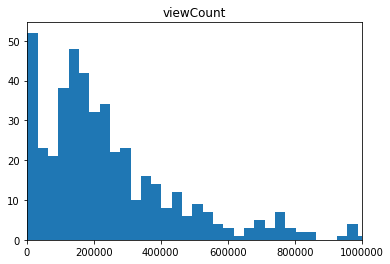

In [2]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv('data/jarujaru_data.csv')
plt.hist(df['viewCount'], bins=200)
plt.title('viewCount')
plt.xlim([0, 1000000])
plt.show()

In [199]:
import re
import pandas as pd
info = []
df = pd.read_csv('data/jarujaru_data.csv')
for row, item in df.iterrows():
    if '『' in item['title']:
        title = 'x' + item['title']
        title = re.split('[『』]', title)[1]
        if item['viewCount'] >= 250000:
            label = 2
        elif 100000 <= item['viewCount'] < 250000:
            label = 1
        elif item['viewCount'] < 100000:
            label = 0
        info.extend([[title, item['viewCount'], item['likeCount'], item['dislikeCount'], item['commentCount'], label]])
        
pd.DataFrame(info, columns=['title', 'viewCount', 'likeCount', 'dislikeCount', 'commentCount', 'label']).to_csv('data/jarujaru_norm.csv')

In [1]:
import analysis
import pandas as pd

df = pd.read_csv('data/jarujaru_norm.csv')
words = analysis.get_words(df['title'])
#print(words)

In [2]:
from gensim import corpora

dictionary = corpora.Dictionary(words)
dictionary.filter_extremes(no_below=2, keep_tokens=['チャラ','男','番長'])
dictionary.save('data/jarujaru.dict')
#dictionary.save_as_text("./tmp/dictionary.txt") で、作成した辞書を保存可能
#dictionary = corpora.Dictionary.load_from_text("./tmp/dictionary.txt") で読み込み
courpus = [dictionary.doc2bow(word) for word in words]
#print(courpus)

In [3]:
dictionary.doc2bow(words[0])

[(0, 1), (1, 1), (2, 1), (3, 1)]

In [4]:
from gensim import matutils

def vec2dense(vec, num_terms):
    return list(matutils.corpus2dense([vec], num_terms=num_terms).T[0])
data_all = [vec2dense(dictionary.doc2bow(words[i]),len(dictionary)) for i in range(len(words))]
#print(data_all[0])

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

#トレーニング・テストデータの設定
train_data = data_all
X_train, X_test, y_train, y_test = train_test_split(train_data, df['label'], test_size=0.2, random_state=1)

#データの標準化
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)


#学習モデルの作成
clf = SVC(C = 1, kernel = 'rbf')
clf.fit(X_train_std, y_train)
import pickle
with open('data/model.pickle', mode='wb') as fp:
     pickle.dump(clf, fp)

In [6]:
score = clf.score(X_test_std, y_test)
print("{:.3g}".format(score))
predicted = clf.predict(X_test_std)

0.527


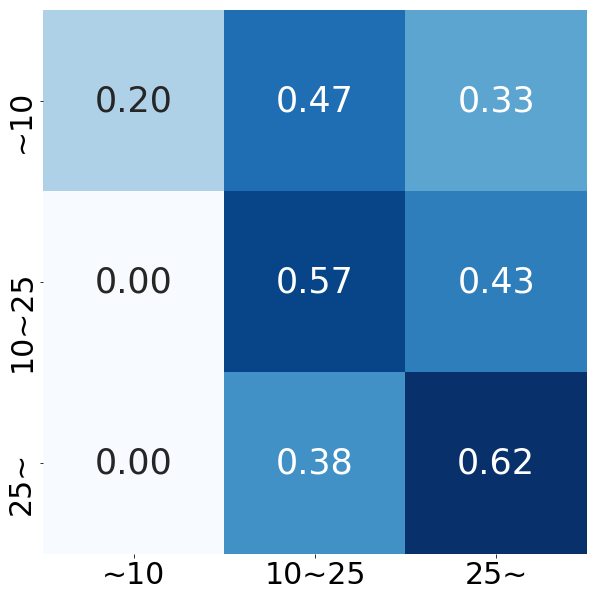

In [7]:
from sklearn.metrics import confusion_matrix
from print_cmx import print_cmx

#cm = confusion_matrix(y_test, predicted)
print_cmx(y_test, predicted, label=['~10','10~25', '25~'])

In [219]:
import pickle
import sys
import analysis
import pandas as pd
from gensim import corpora
from gensim.corpora import Dictionary

args = sys.argv

with open('data/model.pickle', mode='rb') as fp:
    clf = pickle.load(fp)

predict2word = ['見る価値なし','まあまあ', '一見の価値あり']
dictionary = Dictionary.load('data/jarujaru.dict')


title = "ヤバイすぎるヤバイ"
test_words = analysis.get_words([title])
test_dense = [analysis.vec2dense(dictionary.doc2bow(test_words[i]),len(dictionary)) for i in range(len(test_words))]
print(test_words)
predicted0 = clf.predict(test_dense)
print(predict2word[predicted0[0]])

[['ヤバイ', 'すぎる', 'ヤバイ']]
まあまあ


In [179]:
print(dictionary)

Dictionary(106 unique tokens: ['て', 'する', '言う', 'ー', '南']...)
